In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.stats import norm, sem
from scipy.interpolate import UnivariateSpline
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
from numpy.random import default_rng
import random
pd.set_option('display.max_columns', 100)

In [2]:
from metalearners import * 

In [3]:
df = pd.read_csv('GerberGreenLarimer_APSR_2008_social_pressure.csv')
df = df[df['treatment'].isin([' Control',' Neighbors'])]

In [4]:
# df = pd.read_csv('GerberGreenLarimer_APSR_2008_social_pressure.csv')
df['treatment'] = np.where(df.treatment == ' Control',0,1)
df['voted'] = np.where(df.voted == 'Yes', 1, 0)
df['sex'] = np.where(df.sex == 'male',1, 0)
df['g2000'] = np.where(df.g2000 == 'yes', 1, 0)
df['g2002'] = np.where(df.g2002 == 'yes', 1, 0)
df['g2004'] = np.where(df.g2004 == 'yes', 1, 0)
df['p2000'] = np.where(df.p2000 == 'yes', 1, 0)
df['p2002'] = np.where(df.p2002 == 'yes', 1, 0)
df['p2004'] = np.where(df.p2004 == 'Yes', 1, 0)

In [5]:
cts_variables_names = ["yob","treatment","cluster","hh_id","hh_size","numberofnames","p2004_mean","g2004_mean"]
binary_variables_names = ["sex","g2000", "g2002", "p2000", "p2002", "p2004"]
# for column in binary_variables_names:
#     if column == 'sex':
#         df[column] = np.where(df[column] == ' male',1,0)
#     else:
#         df[column] = df[column].str.lower()
#         df[column] = np.where(df[column] == ' yes',1,0)
scaled_cts_covariates = StandardScaler().fit_transform(df[cts_variables_names])
binary_covariates = df[binary_variables_names]
d = pd.DataFrame(np.concatenate((scaled_cts_covariates, binary_covariates), axis=1), 
                        columns=cts_variables_names+binary_variables_names, index=df.index)
d["W"] = df["treatment"]
d["Y"] = df["voted"]

In [6]:
# we need to change Y from binary to numeric, where numeric is the probability of being 1
# so eg: for i with w = 0, we will have prob(yi = 1 | xi) as y0, prob(yi = 1 | xi) + r(x) as y1

def T_learner(d):
    # w == 0
    d0 = d[d['W'] == 0]
    X_d0 = d0.drop(columns=['W','Y'])
    y_d0 = d0['Y']
    clf_d0 = RandomForestClassifier()
    clf_d0.fit(X_d0,y_d0)

    # w == 1
    d1 = d[d['W'] == 1]
    X_d1 = d1.drop(columns=['W','Y'])
    y_d1 = d1['Y']
    clf_d1 = RandomForestClassifier()
    clf_d1.fit(X_d1,y_d1)

    pred_y0 = clf_d0.predict_proba(d.drop(columns= ['W','Y']))[:,1]
    pred_y1 = clf_d1.predict_proba(d.drop(columns= ['W','Y']))[:,1]
    
    ate_score = (sum(pred_y1) - sum(pred_y0)) / len(pred_y0)
    return ate_score, clf_d0, clf_d1

In [7]:
rx, clf_d0, clf_d1 = T_learner(d)
pred_y0 = clf_d0.predict_proba(d.drop(columns= ['W','Y']))[:,1]
pred_y1 = clf_d1.predict_proba(d.drop(columns= ['W','Y']))[:,1]

In [8]:
# replace binary labels by probs 
new_y0 = []
new_y1 = []
Y = []
for i in range(len(d)):
    if d.iloc[i].W == 0.0:
        Y.append(pred_y0[i])
        new_y0.append(pred_y0[i])
        new_y1.append(pred_y0[i] + rx)
    else:
        Y.append(pred_y1[i])
        new_y0.append(pred_y1[i] - rx)
        new_y1.append(pred_y1[i])

d['new_y0'] = new_y0
d['new_y1'] = new_y1
d['Y'] = Y

In [9]:
d

,yob,treatment,cluster,hh_id,hh_size,numberofnames,p2004_mean,g2004_mean,sex,g2000,g2002,p2000,p2002,p2004,W,Y,new_y0,new_y1
5,1.716448,-0.446935,-1.727258,-1.727383,1.031783,0.139749,-1.443668,-0.259034,1.0,0.0,0.0,0.0,0.0,0.0,0,0.01,0.01,0.092175
6,0.195026,-0.446935,-1.727258,-1.727383,1.031783,0.139749,-1.443668,-0.259034,0.0,1.0,1.0,0.0,1.0,0.0,0,0.84,0.84,0.922175
7,-0.012441,-0.446935,-1.727258,-1.727383,1.031783,0.139749,-1.443668,-0.259034,1.0,1.0,1.0,0.0,1.0,0.0,0,0.86,0.86,0.942175
8,0.817426,-0.446935,-1.727258,-1.727364,-0.233199,0.139749,-1.443668,-0.259034,0.0,0.0,0.0,0.0,1.0,0.0,0,0.18,0.18,0.262175
9,0.748270,-0.446935,-1.727258,-1.727364,-0.233199,0.139749,-1.443668,-0.259034,1.0,1.0,1.0,0.0,1.0,0.0,0,0.07,0.07,0.152175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344079,-0.911463,-0.446935,1.736207,1.736332,-0.233199,0.139749,0.952474,0.392520,1.0,1.0,1.0,0.0,1.0,1.0,0,0.77,0.77,0.852175
344080,-0.081596,-0.446935,1.736207,1.736351,-0.233199,0.139749,-0.378716,-0.910586,1.0,1.0,1.0,1.0,0.0,1.0,0,0.12,0.12,0.202175
344081,0.125870,-0.446935,1.736207,1.736351,-0.233199,0.139749,-0.378716,-0.910586,0.0,1.0,0.0,0.0,0.0,0.0,0,0.04,0.04,0.122175
344082,-1.326396,-0.446935,1.736207,1.736371,-0.233199,0.139749,0.153760,-0.910586,1.0,1.0,1.0,1.0,1.0,1.0,0,0.95,0.95,1.032175


In [15]:
def get_samples(data, control_treat_prop, n_training_set = 50000, n_testing_set = 2000):
    
    train_df = data.sample(n_training_set,replace=True)
    test_df = data.sample(n_testing_set,replace=True)
    train_sample=train_df.index
    test_sample=test_df.index
    
    
    # assgin w = 1 according to proprtion
    w_train = np.zeros(len(train_sample))
    w_train[int(len(train_sample) * control_treat_prop) :] = 1 
    w_test = np.zeros(len(test_sample))
    w_test[int(len(test_sample) * control_treat_prop) :] = 1 
    
    # choose new Y
    y_train = []
    y_test = []
    for i in range(len(w_train)):
        if w_train[i] == 0:
            y_train.append(train_df.iloc[i].new_y0)
        else:
            y_train.append(train_df.iloc[i].new_y1)
    for i in range(len(w_test)):
        if w_test[i] == 0:
            y_test.append(test_df.iloc[i].new_y0)
        else:
            y_test.append(test_df.iloc[i].new_y1)
    # add new W,Y to both dfs respectively
    train_df = train_df.drop(columns = ['W','Y','new_y0','new_y1'])
    test_df = test_df.drop(columns = ['W','Y','new_y0','new_y1'])
    train_df['W'] = w_train
    train_df['Y'] = y_train
    test_df['W'] = w_test
    test_df['Y'] = y_test
    
    return train_df, test_df


In [24]:
def get_bootstrap_coverage_CIlength(all_estimates,real_ate, learner_name,  alpha=0.05):
    '''
    params: all_estiamtes: np.matrix, size = (n_models, n_testset)
    real_ate: real ate
    learner_name: meta-learner name 
    '''

    est_stat = []
    signif_level = -norm.ppf(alpha/2)
    ci_lengths = []
    if_covers = 0
    print(learner_name)
    for col in range(all_estimates.shape[1]):
        point_ites = all_estimates[:,col]
        std = np.std(point_ites)
        mean_ite = np.mean(point_ites)
        ci_lengths += [2 * (signif_level * std)]
        if real_ate < (signif_level * std) + mean_ite and real_ate >   mean_ite - (signif_level * std):
            print(real_ate)
            print((signif_level * std) + mean_ite)
            print(mean_ite - (signif_level * std))
            if_covers += 1
    stat = {}
    stat['estimator'] = learner_name
    stat['coverage'] = if_covers / all_estimates.shape[1]
    stat['average_interval_length'] = np.mean(ci_lengths)
    
    return pd.DataFrame([stat])

In [25]:
def boostrap_exp_test_point(data,control_treat_prop,full_ate,  n_training_set = 50000, n_testing_set = 2000):
        Slearner_bool_ates = []
        Xlearner_bool_ates = []
        Tlearner_bool_ates = []
        full_estimate_ate = full_ate
        # only get one test_df
        print('1111')
        _, test_df = get_samples(data,control_treat_prop)
        for time in range(2):
            print(time, ' Finished')
            t_learner = Tlearner(RandomForestRegressor(),RandomForestRegressor(),is_regressor= True)
            s_learner = Slearner(RandomForestRegressor(), is_regressor= True)
            x_learner = Xlearner(RandomForestRegressor(), propensity_model = LogisticRegression(), is_regressor= True)
            train_df, _ = get_samples(data,control_treat_prop)
            # train T S X learner 
            t_learner.fit(train_df.drop(columns = ['W','Y']), train_df['W'], train_df['Y'])
            s_learner.fit(train_df.drop(columns = ['W','Y']), train_df['W'], train_df['Y'])
            x_learner.fit(train_df.drop(columns = ['W','Y']), train_df['W'], train_df['Y'])
            # calculate the ites for all test points 
            s_ite, _, _, _ = s_learner.get_ite(test_df.drop(columns = ['W','Y']), test_df['W'], test_df['Y'])
            x_ite, _, _, _ = x_learner.get_ite(test_df.drop(columns = ['W','Y']), test_df['W'], test_df['Y'])
            t_ite, _, _, _ = t_learner.get_ite(test_df.drop(columns = ['W','Y']), test_df['W'], test_df['Y'])
            Slearner_bool_ates.append(s_ite)
            Xlearner_bool_ates.append(x_ite)
            Tlearner_bool_ates.append(t_ite)
            
        s_result = get_bootstrap_coverage_CIlength(np.array(Slearner_bool_ates), full_estimate_ate,'Slearner',  alpha=0.05)
        t_result = get_bootstrap_coverage_CIlength(np.array(Tlearner_bool_ates), full_estimate_ate,'Tlearner',  alpha=0.05)
        x_result = get_bootstrap_coverage_CIlength(np.array(Xlearner_bool_ates), full_estimate_ate,'Xlearner',  alpha=0.05)
        
        return s_result, t_result, x_result
            


In [ ]:
s_result, t_result, x_result = boostrap_exp_test_point(d, len(d[d['W'] == 1])/len(d[d['W'] == 0]), rx )

In [ ]:
all_result = pd.concat([s_result,t_result,x_result])

In [133]:
all_result

,estimator,coverage,average_interval_length
0,Slearner,0.0,0.0
0,Tlearner,0.0,0.0
0,Xlearner,0.0,0.0


In [122]:
all_result

,estimator,coverage,average_interval_length
0,Slearner,1.0,0.461823
0,Tlearner,1.0,0.554007
0,Xlearner,1.0,0.292478


In [123]:
coverage = all_result['coverage']
average_interval_length = all_result['average_interval_length']
names = all_result['estimator']

In [124]:
average_interval_length

0    0.461823
0    0.554007
0    0.292478
Name: average_interval_length, dtype: float64

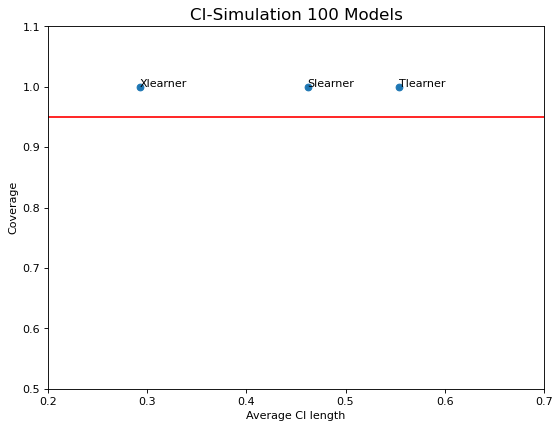

In [125]:
%matplotlib inline
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)


plt.scatter(average_interval_length,coverage)
plt.xlim(0.2,0.7)
plt.ylim(0.5,1.1)
plt.axhline(y=0.95, color='r', linestyle='-')

plt.xlabel("Average CI length")
plt.ylabel("Coverage")
plt.title("CI-Simulation 100 Models",fontsize=15)
annotations = all_result['estimator']
for i, label in enumerate(annotations):
    plt.annotate(label, (average_interval_length.iloc[i], coverage.iloc[i]))


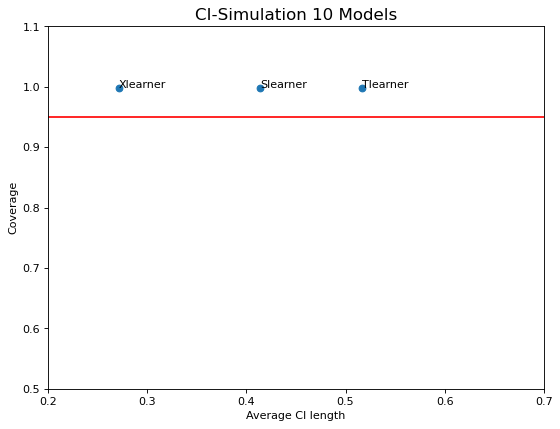

In [115]:
%matplotlib inline
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)


plt.scatter(average_interval_length,coverage)
plt.xlim(0.2,0.7)
plt.ylim(0.5,1.1)
plt.axhline(y=0.95, color='r', linestyle='-')

plt.xlabel("Average CI length")
plt.ylabel("Coverage")
plt.title("CI-Simulation 10 Models",fontsize=15)
annotations = all_result['estimator']
for i, label in enumerate(annotations):
    plt.annotate(label, (average_interval_length.iloc[i], coverage.iloc[i]))


**Boostrap_2 CI**

In [38]:
def boostrap_2_exp_test_point(estimator,data,control_treat_prop,full_ate,  n_training_set = 50000, n_testing_set = 2000):
        bool_ates = []
        all_ates= []
        df = pd.DataFrame(index=data.index)
        cov= pd.DataFrame(index=data.index)
        full_estimate_ate = full_ate
        # only get test_df 
        _, test_df = get_samples(data,control_treat_prop)
        for i in range(10):
            if estimator=='T':
                learner =  Tlearner(RandomForestRegressor(),RandomForestRegressor(),is_regressor= True)
            if estimator=='S':
                learner =  Slearner(RandomForestRegressor(), is_regressor= True)
            if estimator=='X':
                learner=Xlearner(RandomForestRegressor(), propensity_model = LogisticRegression(), is_regressor= True)
            
            train_df, _ = get_samples(data,control_treat_prop)
            # train T-learner
            learner.fit(train_df.drop(columns = ['W','Y']), train_df['W'], train_df['Y'])
            # calculate the ate for boot test set
            ite, _, _ = learner.get_ite(test_df.drop(columns = ['W','Y']), test_df['W'], test_df['Y'])
            all_ates.append(ite)
            bool_ates.append(np.mean(ite))
            train_dict=dict(train_df.index.value_counts())
            df[str(i)]=0
            for j in df.index:
                if j in train_dict:
                    df[str(i)][j]=train_dict[j]
        full_estimate_ate=np.mean(bool_ates)
        df["avg"] = df.mean(1)
        for i in range(10):
            cov[str(i)]=(df[str(i)]-df["avg"])*(bool_ates[i]-full_estimate_ate)
        cov["avg"] = cov.mean(1)
        SD= (sum(cov["avg"]**2))**0.5*0.5
        return get_bootstrap_2_coverage_CIlength(np.array(all_ates), full_estimate_ate,str(estimator)+'_learner', SD, alpha=0.05)

In [39]:
def get_bootstrap_2_coverage_CIlength(all_estimates,real_ate, learner_name, SD=None, alpha=0.05):
    '''
    params: all_estiamtes: np.matrix, size = (n_models, n_testset)
    real_ate: real ate
    learner_name: meta-learner name 
    '''

    est_stat = []
    signif_level = -norm.ppf(alpha/2)
    ci_lengths = []
    if_covers = 0
    print(learner_name)
    for col in range(all_estimates.shape[1]):
        point_ites = all_estimates[:,col]
        if SD is None:
            std = np.std(point_ites)
        else:
            std=SD
        mean_ite = np.mean(point_ites)
        ci_lengths += [2 * (signif_level * std)]
        if real_ate < (signif_level * std) + mean_ite and real_ate >   mean_ite - (signif_level * std):
            print(real_ate)
            print((signif_level * std) + mean_ite)
            print(mean_ite - (signif_level * std))
            if_covers += 1
    stat = {}
    stat['estimator'] = learner_name
    stat['coverage'] = if_covers / all_estimates.shape[1]
    stat['average_interval_length'] = np.mean(ci_lengths)
    
    return pd.DataFrame([stat])

In [40]:
t_result= boostrap_2_exp_test_point('T',d, len(d[d['W'] == 1])/len(d[d['W'] == 0]), rx )

T_learner
0.08395281149349257
0.4664470741719658
-0.516643004516681
0.08395281149349257
0.4681778983921704
-0.5149121802964763
0.08395281149349257
0.6676018681169149
-0.3154882105717318
0.08395281149349257
0.5104226760412551
-0.47266740264739165
0.08395281149349257
0.5487205503072878
-0.4343695283813589
0.08395281149349257
0.5372210113049821
-0.4458690673836646
0.08395281149349257
0.552647502577932
-0.4304425761107147
0.08395281149349257
0.4778445033500895
-0.5052455753385572
0.08395281149349257
0.5892452790687808
-0.3938447996198659
0.08395281149349257
0.5747152953646445
-0.40837478332400223
0.08395281149349257
0.632010181293597
-0.35107989739504974
0.08395281149349257
0.5590252301811884
-0.42406484850745824
0.08395281149349257
0.5975057726582028
-0.38558430603044386
0.08395281149349257
0.5765344548485761
-0.4065556238400706
0.08395281149349257
0.5495548669586785
-0.4335352117299683
0.08395281149349257
0.6413653605481008
-0.34172471814054595
0.08395281149349257
0.4873409787132542
-0.4

0.5291653279563726
-0.4539247507322741
0.08395281149349257
0.5323587877958307
-0.4507312908928161
0.08395281149349257
0.575435756362339
-0.4076543223263077
0.08395281149349257
0.4767905340114239
-0.5062995446772228
0.08395281149349257
0.7044700893095934
-0.27861998937905325
0.08395281149349257
0.6073396771994914
-0.3757504014891553
0.08395281149349257
0.5363449158462706
-0.4467451628423761
0.08395281149349257
0.5895871230595578
-0.3935029556290889
0.08395281149349257
0.5592948995504065
-0.4237951791382403
0.08395281149349257
0.5811357563623389
-0.40195432232630784
0.08395281149349257
0.6498322802270171
-0.3332577984616296
0.08395281149349257
0.5765979146880343
-0.4064921640006124
0.08395281149349257
0.6220801056054577
-0.36100997308318905
0.08395281149349257
0.5726919946230394
-0.4103980840656073
0.08395281149349257
0.6369009624173902
-0.3461891162712564
0.08395281149349257
0.5191918681169148
-0.46389821057173203
0.08395281149349257
0.6397739775550182
-0.34331610113362854
0.08395281149

0.08395281149349257
0.6494975188737964
-0.3335925598148504
0.08395281149349257
0.542708073785887
-0.44038200490275975
0.08395281149349257
0.5212858241719658
-0.46180425451668095
0.08395281149349257
0.5912088366834225
-0.3918812420052242
0.08395281149349257
0.42877967719949095
-0.5543104014891558
0.08395281149349257
0.5693448669586784
-0.41374521172996837
0.08395281149349257
0.615932263931153
-0.3671578147574938
0.08395281149349257
0.5812811215152428
-0.4018089571734039
0.08395281149349257
0.5684170089885099
-0.41467306970013684
0.08395281149349257
0.5108817866375948
-0.4722082920510519
0.08395281149349257
0.642842296522881
-0.3402477821657656
0.08395281149349257
0.6371618518210507
-0.345928226867596
0.08395281149349257
0.6749583919815925
-0.3081316867070543
0.08395281149349257
0.5314948995504064
-0.4515951791382403
0.08395281149349257
0.46171641762390364
-0.5213736610647431
0.08395281149349257
0.6197387877958307
-0.363351290892816
0.08395281149349257
0.6282657726582028
-0.3548243060304

-0.4973660685419008
0.08395281149349257
0.6149618681169148
-0.36812821057173195
0.08395281149349257
0.6851457563623389
-0.29794432232630785
0.08395281149349257
0.48237882038755886
-0.5007112583010879
0.08395281149349257
0.5129749321421344
-0.4701151465465123
0.08395281149349257
0.5524818355251865
-0.4306082431634602
0.08395281149349257
0.5519831533348134
-0.43110692535383327
0.08395281149349257
0.6107127249288471
-0.3723773537597996
0.08395281149349257
0.588619232497661
-0.3944708461909857
0.08395281149349257
0.5602822965228809
-0.42280778216576587
0.08395281149349257
0.5773522802270169
-0.4057377984616299
0.08395281149349257
0.626335707474747
-0.35675437121389975
0.08395281149349257
0.46108880409169484
-0.5220012745969519
0.08395281149349257
0.6123366457659996
-0.3707534329226472
0.08395281149349257
0.5694493355251865
-0.4136407431634602
0.08395281149349257
0.6947700893095936
-0.2883199893790531
0.08395281149349257
0.5692683430940005
-0.4138217355946462
0.08395281149349257
0.578856645

In [41]:
t_result

,estimator,coverage,average_interval_length
0,T_learner,1.0,0.98309


In [42]:
s_result= boostrap_2_exp_test_point('S',d, len(d[d['W'] == 1])/len(d[d['W'] == 0]), rx )

S_learner
0.073035397134304
0.6103497267992881
-0.3948571542081345
0.073035397134304
0.5956145859276931
-0.4095922950797295
0.073035397134304
0.5646853775561698
-0.44052150345125285
0.073035397134304
0.5372244066731893
-0.4679824743342333
0.073035397134304
0.6081213915355614
-0.3970854894718612
0.073035397134304
0.5442687885080358
-0.4609380924993868
0.073035397134304
0.5858165812947487
-0.41939029971267394
0.073035397134304
0.5532871074758988
-0.4519197735315238
0.073035397134304
0.5545643472809141
-0.4506425337265086
0.073035397134304
0.5509925463865484
-0.45421433462087424
0.073035397134304
0.4990796779116964
-0.5061272030957262
0.073035397134304
0.5745431703428825
-0.4306637106645401
0.073035397134304
0.5662278540775707
-0.43897902692985197
0.073035397134304
0.5742178991043755
-0.43098898190304713
0.073035397134304
0.611780551019493
-0.3934263299879296
0.073035397134304
0.5278556755952241
-0.47735120541219855
0.073035397134304
0.5695865161112927
-0.4356203648961299
0.07303539713430

0.5979997105034244
-0.4072071705039982
0.073035397134304
0.585409298393322
-0.4197975826141006
0.073035397134304
0.5875765975906126
-0.41763028341681
0.073035397134304
0.5686541948269572
-0.4365526861804654
0.073035397134304
0.5885870422924429
-0.41661983871497976
0.073035397134304
0.5821610283130512
-0.42304585269437145
0.073035397134304
0.6088784578772535
-0.39632842313016914
0.073035397134304
0.6517362343681024
-0.3534706466393202
0.073035397134304
0.5575166790699325
-0.44769020193749015
0.073035397134304
0.689289934398654
-0.31591694660876857
0.073035397134304
0.5441308164668193
-0.46107606454060335
0.073035397134304
0.6614144555607813
-0.3437924254466414
0.073035397134304
0.6108087070287157
-0.39439817397870697
0.073035397134304
0.46830847417311766
-0.536898406834305
0.073035397134304
0.5250959037373198
-0.4801109772701027
0.073035397134304
0.6138532192304744
-0.3913536617769482
0.073035397134304
0.6055964835195644
-0.3996103974878582
0.073035397134304
0.5839876336570489
-0.421219

0.6253304858360369
-0.3798763951713857
0.073035397134304
0.5943934520860727
-0.41081342892134987
0.073035397134304
0.5846136639323045
-0.42059321707511804
0.073035397134304
0.6729504695401729
-0.3322564114672497
0.073035397134304
0.5394300574300708
-0.46577682357735184
0.073035397134304
0.5763954590354896
-0.428811421971933
0.073035397134304
0.5834634520860728
-0.42174342892134986
0.073035397134304
0.5987468851249836
-0.406459995882439
0.073035397134304
0.5430544229690532
-0.46215245803836946
0.073035397134304
0.579795805962136
-0.4254110750452867
0.073035397134304
0.5546415219024734
-0.4505653591049492
0.073035397134304
0.5299724014208477
-0.47523447958657494
0.073035397134304
0.6100200411342066
-0.39518683987321607
0.073035397134304
0.7524667605492527
-0.25274012045816996
0.073035397134304
0.5407389188749477
-0.4644679621324749
0.073035397134304
0.5656705184277648
-0.4395363625796578
0.073035397134304
0.6015427419369161
-0.40366413907050647
0.073035397134304
0.5870357733704081
-0.418

0.073035397134304
0.5531089188749477
-0.45209796213247483
0.073035397134304
0.5711067605492524
-0.43410012045817026
0.073035397134304
0.5782990779728006
-0.42690780303462206
0.073035397134304
0.6233672052510827
-0.38183967575634
0.073035397134304
0.7081297919827442
-0.29707708902467844
0.073035397134304
0.5149492983933219
-0.4902575826141007
0.073035397134304
0.5592997392343653
-0.4459071417730574
0.073035397134304
0.582655675595224
-0.42255120541219865
0.073035397134304
0.5923600085424787
-0.41284687246494395
0.073035397134304
0.5595613263521053
-0.4456455546553173
0.073035397134304
0.517177633657049
-0.48802924735037356
0.073035397134304
0.669690648794677
-0.3355162322127456
0.073035397134304
0.579681077200643
-0.4255258038067796
0.073035397134304
0.5447348187832914
-0.4604720622241311
0.073035397134304
0.6461766953657966
-0.3590301856416261
0.073035397134304
0.5708996942075604
-0.43430718679986224
0.073035397134304
0.5410970259965788
-0.46410985501084384
0.073035397134304
0.53311302

In [43]:
x_result= boostrap_2_exp_test_point('X',d, len(d[d['W'] == 1])/len(d[d['W'] == 0]), rx )

X_learner
0.08198504252960956
0.4973876375027773
-0.3876359776158838
0.08198504252960956
0.5087928471879368
-0.37623076793072424
0.08198504252960956
0.5224073891782635
-0.36261622594039766
0.08198504252960956
0.5157054795426312
-0.3693181355760299
0.08198504252960956
0.4933054576332666
-0.3917181574853945
0.08198504252960956
0.528440863289466
-0.35658275182919513
0.08198504252960956
0.585221249445946
-0.2998023656727151
0.08198504252960956
0.5582458090766304
-0.32677780604203077
0.08198504252960956
0.5257413934286563
-0.35928222169000484
0.08198504252960956
0.5414944890051937
-0.3435291261134674
0.08198504252960956
0.5196136625389233
-0.36540995257973785
0.08198504252960956
0.5414230624635823
-0.3436005526550788
0.08198504252960956
0.5386758400716355
-0.34634777504702563
0.08198504252960956
0.532698415684048
-0.35232519943461316
0.08198504252960956
0.5340045800371006
-0.3510190350815605
0.08198504252960956
0.5443787529773688
-0.3406448621412923
0.08198504252960956
0.5608654676887227
-0

-0.3416667669013419
0.08198504252960956
0.5161819671228709
-0.3688416479957902
0.08198504252960956
0.47388766907657276
-0.41113594604208836
0.08198504252960956
0.5280560615253194
-0.3569675535933418
0.08198504252960956
0.4999075009783709
-0.38511611414029023
0.08198504252960956
0.5170543834146692
-0.3679692317039919
0.08198504252960956
0.5327050796799674
-0.35231853543869374
0.08198504252960956
0.4467876266915323
-0.4382359884271288
0.08198504252960956
0.5360591936185374
-0.3489644215001238
0.08198504252960956
0.5485073347287626
-0.33651628038989856
0.08198504252960956
0.5379004254085494
-0.3471231897101117
0.08198504252960956
0.536096755963813
-0.34892685915484817
0.08198504252960956
0.5200191309380964
-0.36500448418056475
0.08198504252960956
0.5124568410345529
-0.3725667740841082
0.08198504252960956
0.5339888895521637
-0.3510347255664974
0.08198504252960956
0.5429795278184819
-0.34204408730017927
0.08198504252960956
0.527729099972164
-0.3572945151464971
0.08198504252960956
0.51127568

0.49982140566364
-0.38520220945502115
0.08198504252960956
0.5104857108076001
-0.374537904311061
0.08198504252960956
0.5177232243616292
-0.3673003907570319
0.08198504252960956
0.517387230348564
-0.3676363847700971
0.08198504252960956
0.518210082615649
-0.3668135325030121
0.08198504252960956
0.5397908527980723
-0.34523276232058886
0.08198504252960956
0.5114364692723157
-0.3735871458463455
0.08198504252960956
0.5057386853533636
-0.37928492976529754
0.08198504252960956
0.5469513987754578
-0.3380722163432033
0.08198504252960956
0.5203104549361857
-0.36471316018247546
0.08198504252960956
0.5428886059788871
-0.342135009139774
0.08198504252960956
0.5293567673253089
-0.3556668477933522
0.08198504252960956
0.5065653961499177
-0.3784582189687435
0.08198504252960956
0.5610733758580203
-0.3239502392606408
0.08198504252960956
0.5519358342662419
-0.3330877808524192
0.08198504252960956
0.485959611761724
-0.39906400335693715
0.08198504252960956
0.5099411599911832
-0.37508245512747795
0.0819850425296095

0.08198504252960956
0.497913706355233
-0.3871099087634281
0.08198504252960956
0.5560333148875201
-0.328990300231141
0.08198504252960956
0.5132356683985093
-0.37178794672015186
0.08198504252960956
0.5520232802061809
-0.3330003349124803
0.08198504252960956
0.5120411299812342
-0.372982485137427
0.08198504252960956
0.5032737414306936
-0.3817498736879675
0.08198504252960956
0.5316707464257471
-0.35335286869291405
0.08198504252960956
0.4938532535289647
-0.3911703615896964
0.08198504252960956
0.47654608293923334
-0.4084775321794278
0.08198504252960956
0.5528259373413384
-0.3321976777773227
0.08198504252960956
0.5304791488843543
-0.3545444662343068
0.08198504252960956
0.5377537617638034
-0.3472698533548577
0.08198504252960956
0.5247904948046697
-0.3602331203139914
0.08198504252960956
0.5065915298395658
-0.37843208527909533
0.08198504252960956
0.5507740326827228
-0.33424958243593833
0.08198504252960956
0.5174587799003821
-0.367564835218279
0.08198504252960956
0.5203462375777186
-0.3646773775409

In [44]:
all_result = pd.concat([s_result,t_result,x_result])

In [47]:
coverage = all_result['coverage']
average_interval_length = all_result['average_interval_length']
names = all_result['estimator']

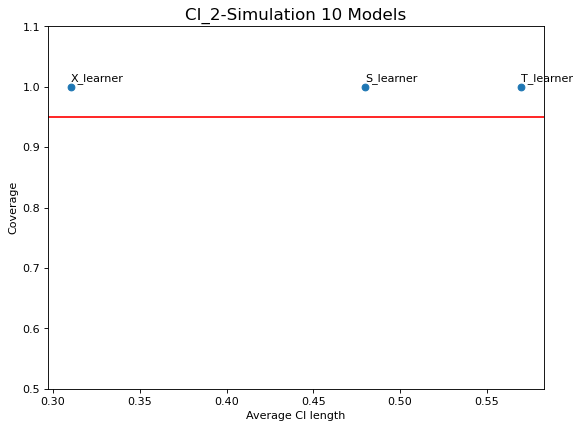

In [18]:
%matplotlib inline
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)


plt.scatter(average_interval_length,coverage)
# plt.xlim(0.2,0.7)
plt.ylim(0.5,1.1)
plt.axhline(y=0.95, color='r', linestyle='-')

plt.xlabel("Average CI length")
plt.ylabel("Coverage")
plt.title("CI_2-Simulation 10 Models",fontsize=15)
annotations = all_result['estimator']
for i, label in enumerate(annotations):
    plt.annotate(label, (average_interval_length.iloc[i], coverage.iloc[i]+0.01))

